## Homework wk 08

This work was done in google colab via GPU. But it should work on CPU as well.

In [1]:
!wget 'https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip'
!unzip data.zip

--2025-12-03 16:59:10--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-03T17%3A43%3A35Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-03T16%3A42%3A36Z&ske=2025-12-03T17%3A43%3A35Z&sks=b&skv=2018-11-09&sig=LlkWGgrkfBrAPk%2FHg81PKpBL2fHvku3sEYodCklJ96c%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDc4Mjk1MCwibmJmIjoxNzY0NzgxMTUwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [5]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

array([[[ 95,  86,  71],
        [ 97,  88,  73],
        [ 97,  88,  73],
        ...,
        [146, 141, 119],
        [146, 141, 119],
        [148, 143, 121]],

       [[ 97,  87,  70],
        [ 99,  90,  72],
        [ 98,  88,  72],
        ...,
        [148, 143, 121],
        [147, 142, 120],
        [148, 143, 121]],

       [[ 99,  87,  67],
        [101,  89,  69],
        [100,  88,  71],
        ...,
        [150, 145, 123],
        [146, 141, 119],
        [147, 142, 120]],

       ...,

       [[116,  82,  57],
        [117,  83,  58],
        [118,  84,  59],
        ...,
        [220, 219, 214],
        [221, 220, 215],
        [223, 222, 217]],

       [[117,  83,  58],
        [119,  85,  60],
        [120,  86,  61],
        ...,
        [221, 220, 215],
        [222, 221, 216],
        [221, 220, 215]],

       [[119,  85,  60],
        [120,  86,  61],
        [119,  85,  60],
        ...,
        [218, 217, 212],
        [221, 220, 215],
        [221, 220, 215]]], dtype=uint8)
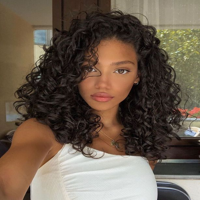

In [6]:
from PIL import Image

img = Image.open('/content/data/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')
X = np.array(img.resize((200, 200)))
X

You need to develop the model with following structure:

- The shape for input should be (3, 200, 200) (channels first format in PyTorch)
- Next, create a convolutional layer (nn.Conv2d):
- Use 32 filters (output channels)
- Kernel size should be (3, 3) (that's the size of the filter), padding = 0, stride = 1
- Use 'relu' as activation
- Reduce the size of the feature map with max pooling (nn.MaxPool2d)
- Set the pooling size to (2, 2)
- Turn the multi-dimensional result into vectors using flatten or view
- Next, add a nn.Linear layer with 64 neurons and 'relu' activation
- Finally, create the nn.Linear layer with 1 neuron - this will be the output
- The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use torch.optim.SGD with the following parameters:

- torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [8]:
class HairClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    #original input img (3, 200, 200)

    self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
    #conv2d transforms img. output = (200 - 3 + 0)/1 = 198, see below

    self.pool = nn.MaxPool2d(2, 2)
    #pooling downsizes image 198/2 = 99 -> (32, 99, 99)

    self.fc1 = nn.Linear(32*99*99, 64)
    self.fc2 = nn.Linear(64, 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    return self.fc2(x)

For a Conv2d layer:
$$ Output = \dfrac{(W - K + 2P)}{S} +1, $$
where $W$ is input width/height, $K$ is kernel size, $P$ is padding, $S$ is stride.

No activation needed if using `nn.BCEWithLogitsLoss()`, as this takes raw scores and convertd them to probabilities.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running on:", device)

model = HairClassifier()
model.to(device)


running on: cuda


HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

In [11]:
from torchsummary import summary

summary(model, input_size=(3, 200, 200), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Linear-3                   [-1, 64]      20,072,512
            Linear-4                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.96
Params size (MB): 76.57
Estimated Total Size (MB): 89.00
----------------------------------------------------------------


### Generators and training

In [16]:
import os
from torch.utils.data import Dataset

#image data generator
class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [19]:
# create dataloaders

from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir='/content/data/train',
    transform=train_transforms
)

val_dataset = HairDataset(
    data_dir='/content/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [21]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.5562, Acc: 0.7166, Val Loss: 0.5934, Val Acc: 0.6667
Epoch 2/10, Loss: 0.5282, Acc: 0.7253, Val Loss: 0.6028, Val Acc: 0.6269
Epoch 3/10, Loss: 0.4641, Acc: 0.7566, Val Loss: 0.6504, Val Acc: 0.6418
Epoch 4/10, Loss: 0.4014, Acc: 0.8190, Val Loss: 1.0123, Val Acc: 0.5821
Epoch 5/10, Loss: 0.4390, Acc: 0.7903, Val Loss: 0.6693, Val Acc: 0.6915
Epoch 6/10, Loss: 0.3171, Acc: 0.8589, Val Loss: 0.7245, Val Acc: 0.6816
Epoch 7/10, Loss: 0.2277, Acc: 0.9139, Val Loss: 0.7918, Val Acc: 0.6716
Epoch 8/10, Loss: 0.2402, Acc: 0.8914, Val Loss: 0.6845, Val Acc: 0.6716
Epoch 9/10, Loss: 0.1447, Acc: 0.9488, Val Loss: 0.8024, Val Acc: 0.6965
Epoch 10/10, Loss: 0.1455, Acc: 0.9413, Val Loss: 0.7737, Val Acc: 0.7463


In [34]:
import statistics

statistics.median(history['acc'])

0.8389513108614233

In [35]:
statistics.stdev(history['loss'])

0.15267816016230634

## Data Augmentation

In [36]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [37]:
# create dataloaders

from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir='/content/data/train',
    transform=train_transforms
)

val_dataset = HairDataset(
    data_dir='/content/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [38]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6934, Acc: 0.6192, Val Loss: 0.5897, Val Acc: 0.6915
Epoch 2/10, Loss: 0.5722, Acc: 0.6929, Val Loss: 0.6687, Val Acc: 0.6617
Epoch 3/10, Loss: 0.5416, Acc: 0.7278, Val Loss: 0.6167, Val Acc: 0.6866
Epoch 4/10, Loss: 0.5372, Acc: 0.7129, Val Loss: 0.5736, Val Acc: 0.6915
Epoch 5/10, Loss: 0.5049, Acc: 0.7416, Val Loss: 0.5741, Val Acc: 0.6716
Epoch 6/10, Loss: 0.5148, Acc: 0.7478, Val Loss: 0.5516, Val Acc: 0.7214
Epoch 7/10, Loss: 0.4956, Acc: 0.7591, Val Loss: 0.6761, Val Acc: 0.6915
Epoch 8/10, Loss: 0.4810, Acc: 0.7690, Val Loss: 0.5760, Val Acc: 0.7463
Epoch 9/10, Loss: 0.4814, Acc: 0.7703, Val Loss: 0.7635, Val Acc: 0.6517
Epoch 10/10, Loss: 0.5203, Acc: 0.7378, Val Loss: 0.6443, Val Acc: 0.6567


In [39]:
statistics.mean(history['val_loss'])

0.6234383432722803

In [40]:
statistics.mean(history['val_acc'][6:10])

0.6865671641791045